<a href="https://colab.research.google.com/github/TheAnh23/Sales_volume_forecasting/blob/main/sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import library**

In [100]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Concatenate, Input, LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

# **Load dataset**

- Link data: https://www.kaggle.com/datasets/ddosad/dummy-truck-sales-for-time-series/code
- Link code: https://www.kaggle.com/code/ddosad/time-series-arma-arima-sarima-concepts

In [80]:
df = pd.read_csv('/content/drive/MyDrive/TÀI LIỆU HỌC TẬP UEL/HK5/WEB/WEB_T/CODE/archive/Truck_sales.csv')

In [81]:
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(df), name='month')
#Dropping the original Month-Year column
df.drop(['Month-Year'], axis=1, inplace=True)
df.rename(columns={'Number_Trucks_Sold':'value'}, inplace=True) #renaming Number_Trucks_Sold column
df = df[['value']]
df.set_index(dates, inplace=True)
df.head()

,value
month,
2003-01-01,155
2003-02-01,173
2003-03-01,204
2003-04-01,219
2003-05-01,223


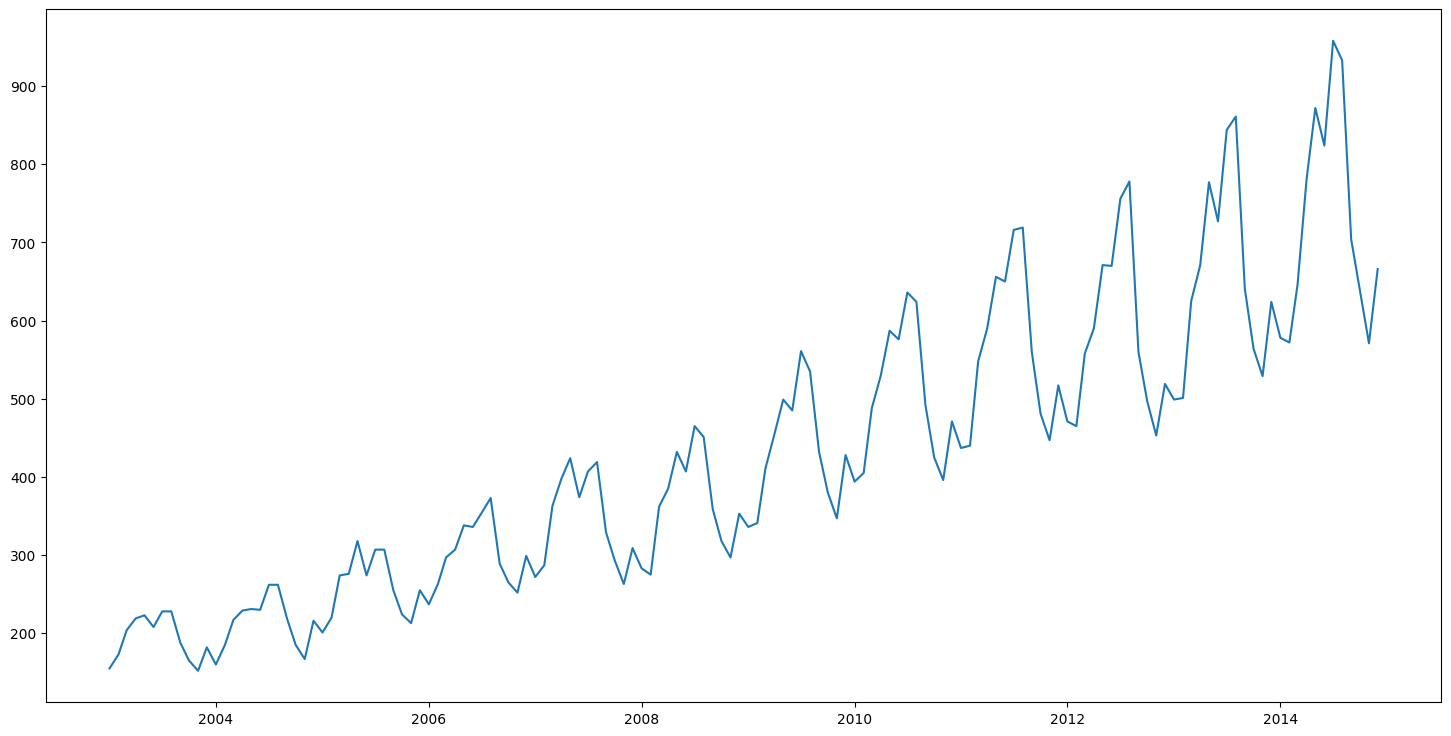

In [167]:
plt.figure(figsize=(18,9))
plt.plot(df.index, df["value"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show();

<Figure size 1600x700 with 0 Axes>

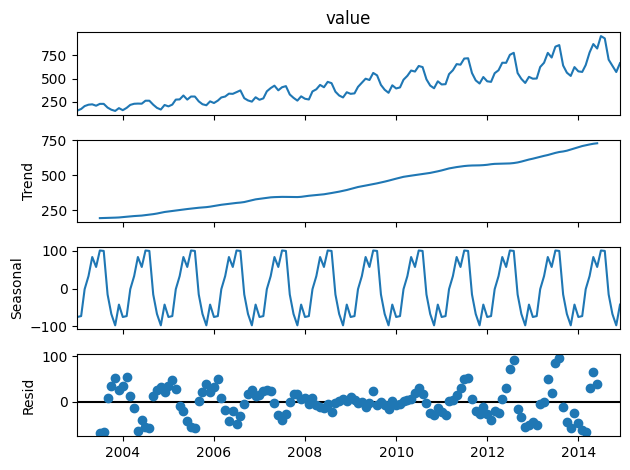

In [165]:
a = seasonal_decompose(df["value"], model = "add")
plt.figure(figsize = (16,7))
a.plot();

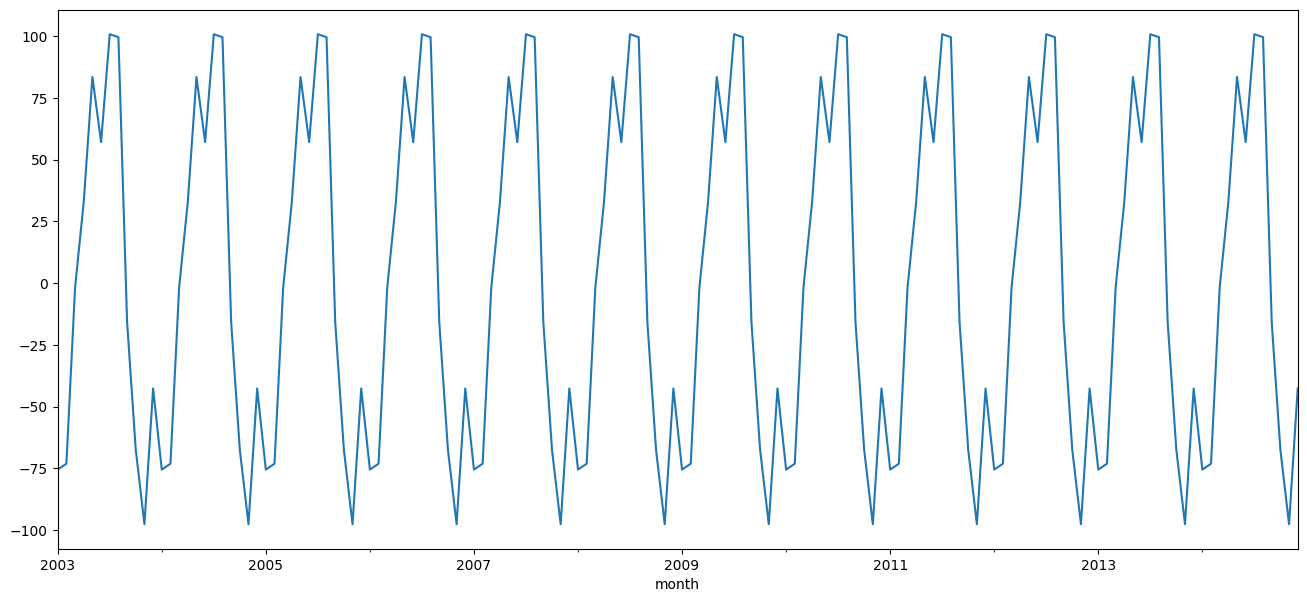

In [166]:
plt.figure(figsize = (16,7))
a.seasonal.plot();

# **Forecasting**

In [128]:
scaler = MinMaxScaler()

def load_data(df, n_test):
    train = df[:len(df)-n_test]
    test = df[len(df)-n_test:]
    return train, test

def ARIMA_model(train, test, n_test):
    # Chạy mô hình ARIMA
    arima_model = SARIMAX(train['value'], order = (1,0,1), seasonal_order = (1,0,1,n_test))
    arima_result = arima_model.fit()
    arima_pred = arima_result.predict(start = len(train), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
    return arima_pred

def LSTM_model(train, test, n_input, n_features):
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    lstm_model = Sequential()
    lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit_generator(generator,epochs=40)
    lstm_predictions_scaled = list()
    batch = scaled_train[-n_input:]
    current_batch = batch.reshape((1, n_input, n_features))
    for i in range(len(test_data)):
        lstm_pred = lstm_model.predict(current_batch)[0]
        lstm_predictions_scaled.append(lstm_pred)
        current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)
    lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
    return lstm_predictions

def linear_blend(predictions_arima, predictions_lstm, alpha):
    return alpha * predictions_arima + (1 - alpha) * predictions_lstm

def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    nonzero_elements = actual != 0  # Avoid division by zero
    mape = np.mean(np.abs((actual[nonzero_elements] - predicted[nonzero_elements]) / actual[nonzero_elements])) * 100
    return mape

def calculate_r_squared(actual, predicted):
    r_squared = r2_score(actual, predicted)
    return r_squared

def evaluate(test_data):
    rmse_errors = []
    mse_errors = []
    mapes = []
    r_squareds = []

    actual_values = test_data['value']  # Giả sử cột này chứa giá trị thực tế

    # Đánh giá ARIMA
    arima_rmse_error = rmse(actual_values, test_data['ARIMA_Predictions'])
    arima_mape = calculate_mape(actual_values, test_data['ARIMA_Predictions'])
    arima_r_squared = calculate_r_squared(actual_values, test_data['ARIMA_Predictions'])
    arima_mse_error = arima_rmse_error**2
    rmse_errors.append(arima_rmse_error)
    mse_errors.append(arima_mse_error)
    mapes.append(arima_mape)
    r_squareds.append(arima_r_squared)

    # Đánh giá LSTM
    lstm_rmse_error = rmse(actual_values, test_data['LSTM_Predictions'])
    lstm_mape = calculate_mape(actual_values, test_data['LSTM_Predictions'])
    lstm_r_squared = calculate_r_squared(actual_values, test_data['LSTM_Predictions'])
    lstm_mse_error = lstm_rmse_error**2
    rmse_errors.append(lstm_rmse_error)
    mse_errors.append(lstm_mse_error)
    mapes.append(lstm_mape)
    r_squareds.append(lstm_r_squared)

    # Đánh giá Hybrid
    hybrid_rmse_error = rmse(actual_values, test_data['Hybrid_Predictions'])
    hybrid_mape = calculate_mape(actual_values, test_data['Hybrid_Predictions'])
    hybrid_r_squared = calculate_r_squared(actual_values, test_data['Hybrid_Predictions'])
    hybrid_mse_error = hybrid_rmse_error**2
    rmse_errors.append(hybrid_rmse_error)
    mse_errors.append(hybrid_mse_error)
    mapes.append(hybrid_mape)
    r_squareds.append(hybrid_r_squared)

    errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Hybrid"],
                           "RMSE Errors" : rmse_errors,
                           "MSE Errors" : mse_errors,
                           'MAPE': mapes,
                           'R-Squared': r_squareds})
    return errors

In [160]:
n_test = 12
n_features = 1
train_data, test_data = load_data(df, n_test)
test_data['LSTM_Predictions'] = LSTM_model(train_data, test_data, n_test, n_features)
test_data['ARIMA_Predictions'] = ARIMA_model(train_data, test_data, n_test)
test_data['Hybrid_Predictions'] = linear_blend(test_data['ARIMA_Predictions'], test_data['LSTM_Predictions'], 0.71)
result = evaluate(test_data)

In [161]:
result

,Models,RMSE Errors,MSE Errors,MAPE,R-Squared
0,ARIMA,29.280469,857.345844,3.326003,0.952857
1,LSTM,35.724955,1276.272424,3.949849,0.929821
2,Hybrid,27.846243,775.413244,2.893750,0.957362


In [162]:
test_data

,value,LSTM_Predictions,ARIMA_Predictions,Hybrid_Predictions
month,,,,
2014-01-01,578,537.799599,593.544062,577.378168
2014-02-01,572,554.588953,591.741477,580.967245
2014-03-01,646,651.772766,707.016906,690.996106
2014-04-01,781,717.943628,747.751843,739.107461
2014-05-01,872,801.497507,845.982959,833.082178
2014-06-01,824,810.049601,798.020549,801.508974
2014-07-01,958,909.697281,906.657787,907.539241
2014-08-01,933,914.669810,920.744691,918.982976
2014-09-01,704,710.218978,704.678175,706.285008


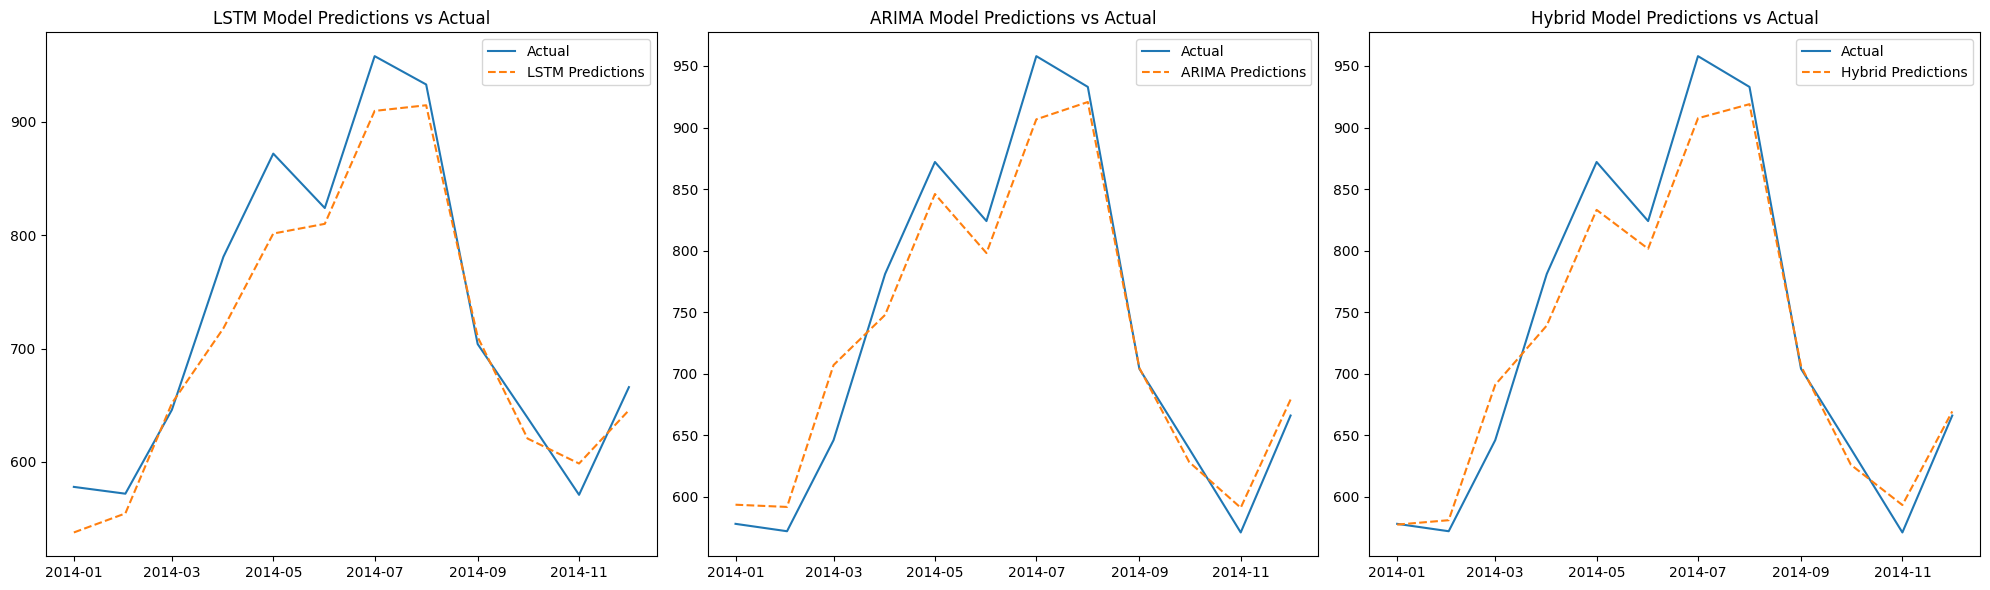

In [163]:
import matplotlib.pyplot as plt

# Tạo một lưới biểu đồ với 1 hàng và 3 cột
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

axes[0].plot(test_data.index, test_data["value"], label='Actual')
axes[0].plot(test_data.index, test_data["LSTM_Predictions"], label='LSTM Predictions', linestyle='--')
axes[0].legend()
axes[0].set_title('LSTM Model Predictions vs Actual')

axes[1].plot(test_data.index, test_data["value"], label='Actual')
axes[1].plot(test_data.index, test_data["ARIMA_Predictions"], label='ARIMA Predictions', linestyle='--')
axes[1].legend()
axes[1].set_title('ARIMA Model Predictions vs Actual')

# Vẽ từng biểu đồ trên từng cột của lưới
axes[2].plot(test_data.index, test_data["value"], label='Actual')
axes[2].plot(test_data.index, test_data["Hybrid_Predictions"], label='Hybrid Predictions', linestyle='--')
axes[2].legend()
axes[2].set_title('Hybrid Model Predictions vs Actual')

plt.tight_layout()
plt.show()

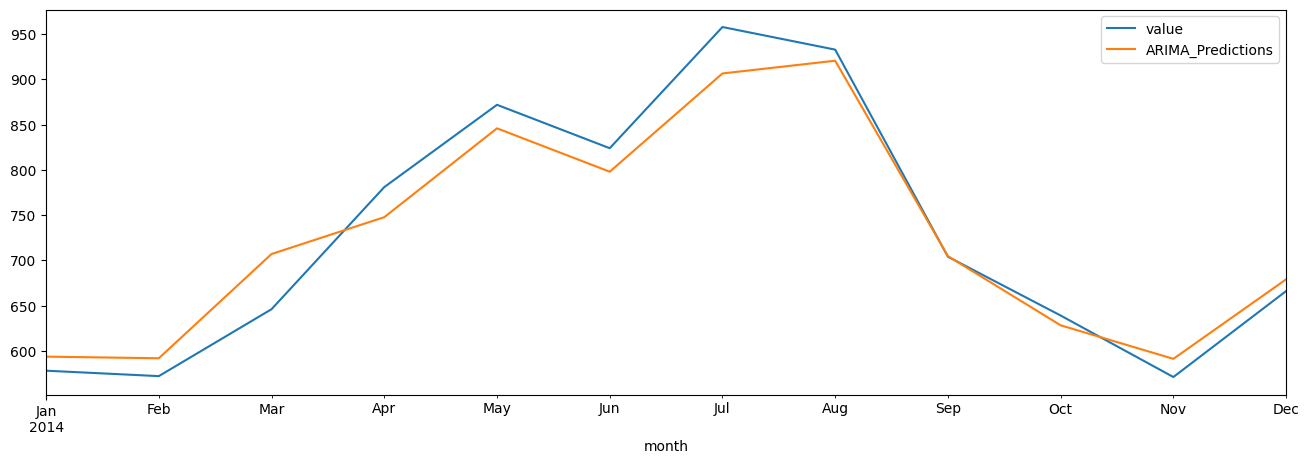

In [168]:
test_data['value'].plot(figsize = (16,5), legend=True)
test_data['ARIMA_Predictions'].plot(legend = True);

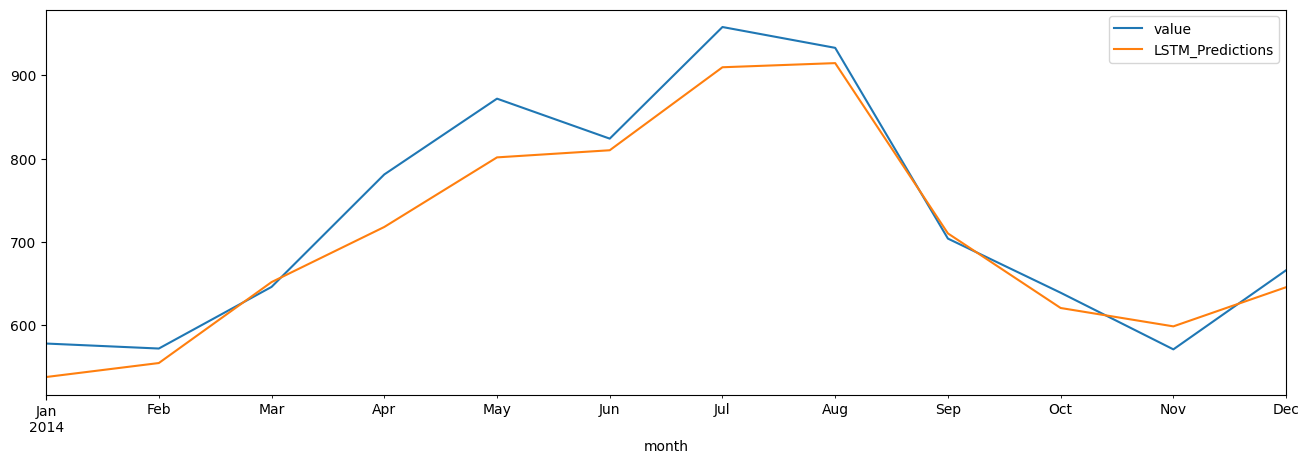

In [169]:
test_data['value'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

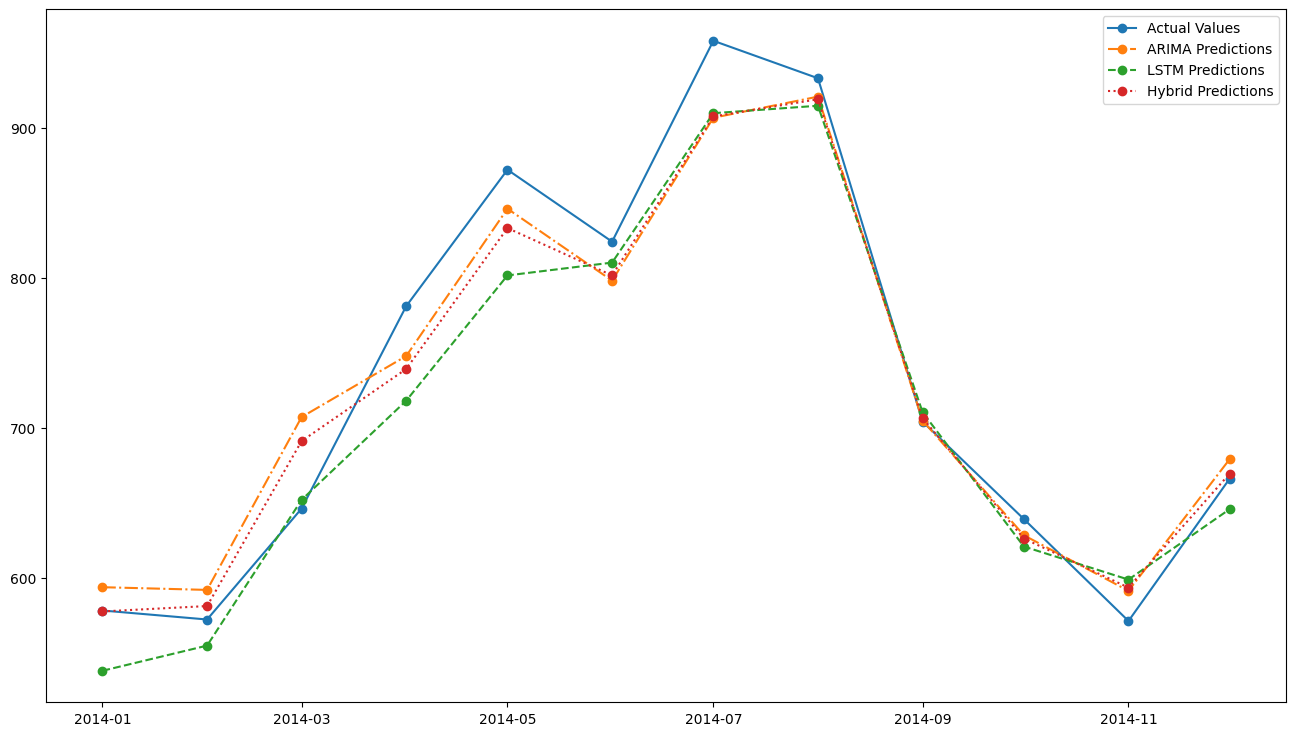

In [171]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["value"], linestyle="-", label="Actual Values")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.", label="ARIMA Predictions")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--", label="LSTM Predictions")
plt.plot_date(test_data.index, test_data["Hybrid_Predictions"], linestyle=":", label="Hybrid Predictions")
plt.legend()
plt.show()